# 08 - Hyperparameter Tuning with Optuna

This notebook uses Optuna to optimize hyperparameters for all ensemble component models:
- **XGBoost**: n_estimators, max_depth, learning_rate, min_child_weight
- **LightGBM**: n_estimators, max_depth, learning_rate, num_leaves
- **Prophet**: seasonality_prior_scale, seasonality_mode, changepoint_prior_scale, n_changepoints, changepoint_range

## Optimization Strategy

- **Method**: Bayesian optimization with TPE (Tree-structured Parzen Estimator)
- **Objective**: Minimize mean MAE across walk-forward validation folds
- **Trials**: 50 trials per model with median pruning

## 1. Setup and Imports

In [1]:
import sys
import json
import warnings
from pathlib import Path
from datetime import date

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

# Add src to path for imports
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

# Import evaluation tools
from volume_forecast.evaluation import WalkForwardValidator

# Import models
from volume_forecast.models import XGBoostModel, LightGBMModel, ProphetModel

# Import feature pipeline
from volume_forecast.features import FeaturePipeline

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

print(f"Optuna version: {optuna.__version__}")
print("Setup complete!")

Optuna version: 4.6.0
Setup complete!


## 2. Load and Prepare Data

In [2]:
# Load data
data_path = project_root / "data" / "raw" / "synthetic_volumes.csv"
df = pd.read_csv(data_path, parse_dates=["date"])
df = df.sort_values('date').reset_index(drop=True)

print(f"Loaded data: {len(df)} rows")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")

Loaded data: 731 rows
Date range: 2023-01-01 to 2024-12-31


In [3]:
# Apply Feature Pipeline
pipeline = FeaturePipeline(
    date_column='date',
    target_columns=['daily_logins'],
    include_events=True,
    include_football=True,
)
df_features = pipeline.fit_transform(df)
print(f"Features generated: {len(pipeline.get_feature_names())} columns")
print(f"Dataset shape: {df_features.shape}")

Features generated: 46 columns
Dataset shape: (731, 50)


In [4]:
# Define constants
TARGET = 'daily_logins'
DATE_COLUMN = 'date'

# External features for enhanced model (same as notebook 07)
EXTERNAL_FEATURES = [
    # Temporal features
    'day_of_week', 'is_weekend', 'day_of_week_sin', 'day_of_week_cos',
    'month', 'month_sin', 'month_cos',
    
    # Rolling statistics
    'daily_logins_rolling_mean_7', 'daily_logins_rolling_mean_14', 'daily_logins_rolling_mean_30',
    'daily_logins_rolling_std_7', 'daily_logins_rolling_std_14', 'daily_logins_rolling_std_30',
    
    # Event flags (same-day)
    'is_bank_holiday', 'is_racing_event', 'is_tennis_event',
    'is_boxing_event', 'is_football_match', 'event_importance',
    
    # Lead indicators (upcoming events)
    'any_event_tomorrow', 'any_event_in_2_days', 'any_event_in_3_days',
    'bank_holiday_tomorrow', 'bank_holiday_in_2_days', 'bank_holiday_in_3_days',
    'football_tomorrow', 'football_in_2_days', 'football_in_3_days',
    
    # Lag indicators (past events)
    'any_event_yesterday', 'any_event_2_days_ago',
    'bank_holiday_yesterday', 'bank_holiday_2_days_ago',
    'football_yesterday', 'football_2_days_ago',
]

# Regressors for Prophet (event features only)
PROPHET_REGRESSORS = [
    'is_bank_holiday', 'is_racing_event', 'is_tennis_event',
    'is_boxing_event', 'is_football_match', 'event_importance',
    # Lead indicators
    'any_event_tomorrow', 'any_event_in_2_days', 'any_event_in_3_days',
    'bank_holiday_tomorrow', 'bank_holiday_in_2_days', 'bank_holiday_in_3_days',
    'football_tomorrow', 'football_in_2_days', 'football_in_3_days',
    # Lag indicators
    'any_event_yesterday', 'any_event_2_days_ago',
    'bank_holiday_yesterday', 'bank_holiday_2_days_ago',
    'football_yesterday', 'football_2_days_ago',
]

print(f"External features: {len(EXTERNAL_FEATURES)}")
print(f"Prophet regressors: {len(PROPHET_REGRESSORS)}")

External features: 34
Prophet regressors: 21


## 3. Define Objective Function

In [5]:
# Create validator (same settings as notebook 07)
validator = WalkForwardValidator(
    min_train_size=365,
    test_size=7,
    step_size=7
)

n_folds = validator.get_n_splits(df_features, date_column=DATE_COLUMN)
print(f"Walk-forward validation: {n_folds} folds")

Walk-forward validation: 52 folds


In [6]:
def objective(trial: optuna.Trial) -> float:
    """Optuna objective function for XGBoost hyperparameter optimization.
    
    Returns mean MAE across walk-forward validation folds.
    """
    # Sample hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    
    # Create model with sampled parameters
    model = XGBoostModel(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        lags=[1, 7, 14],
        external_features=EXTERNAL_FEATURES,
        name='XGBoost_Tuning'
    )
    
    # Run walk-forward validation
    fold_results = validator.validate(
        model=model,
        df=df_features,
        target=TARGET,
        date_column=DATE_COLUMN,
        feature_columns=EXTERNAL_FEATURES + [DATE_COLUMN]
    )
    
    # Calculate mean MAE
    mae_values = [r['metrics']['mae'] for r in fold_results]
    mean_mae = np.mean(mae_values)
    
    return mean_mae

## 4. Run Optimization

In [7]:
# Create Optuna study
study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=10)
)

print("Starting hyperparameter optimization...")
print(f"Trials: 50")
print(f"Folds per trial: {n_folds}")
print("="*60)

Starting hyperparameter optimization...
Trials: 50
Folds per trial: 52


In [8]:
# Run optimization with progress callback
def callback(study: optuna.Study, trial: optuna.trial.FrozenTrial):
    if trial.number % 5 == 0 or trial.number == 0:
        print(f"Trial {trial.number:3d}: MAE = {trial.value:.2f} | Best so far: {study.best_value:.2f}")

study.optimize(
    objective,
    n_trials=50,
    callbacks=[callback],
    show_progress_bar=True
)

print("="*60)
print("Optimization complete!")

  0%|          | 0/50 [00:00<?, ?it/s]

Trial   0: MAE = 5702.06 | Best so far: 5702.06


Trial   5: MAE = 4981.30 | Best so far: 4981.30


Trial  10: MAE = 5374.18 | Best so far: 4762.17


Trial  15: MAE = 4872.04 | Best so far: 4762.17


Trial  20: MAE = 5535.27 | Best so far: 4762.17


Trial  25: MAE = 5038.62 | Best so far: 4762.17


Trial  30: MAE = 5657.78 | Best so far: 4761.37


Trial  35: MAE = 5688.05 | Best so far: 4761.37


Trial  40: MAE = 5108.82 | Best so far: 4761.37


Trial  45: MAE = 8787.93 | Best so far: 4761.37


Optimization complete!


## 5. Analyze Results

In [9]:
# Display best parameters
print("="*60)
print("BEST HYPERPARAMETERS")
print("="*60)
print(f"\nBest MAE: {study.best_value:.2f}")
print(f"\nBest Parameters:")
for param, value in study.best_params.items():
    print(f"  {param}: {value}")

BEST HYPERPARAMETERS

Best MAE: 4761.37

Best Parameters:
  n_estimators: 88
  max_depth: 3
  learning_rate: 0.11051172878006565
  min_child_weight: 8


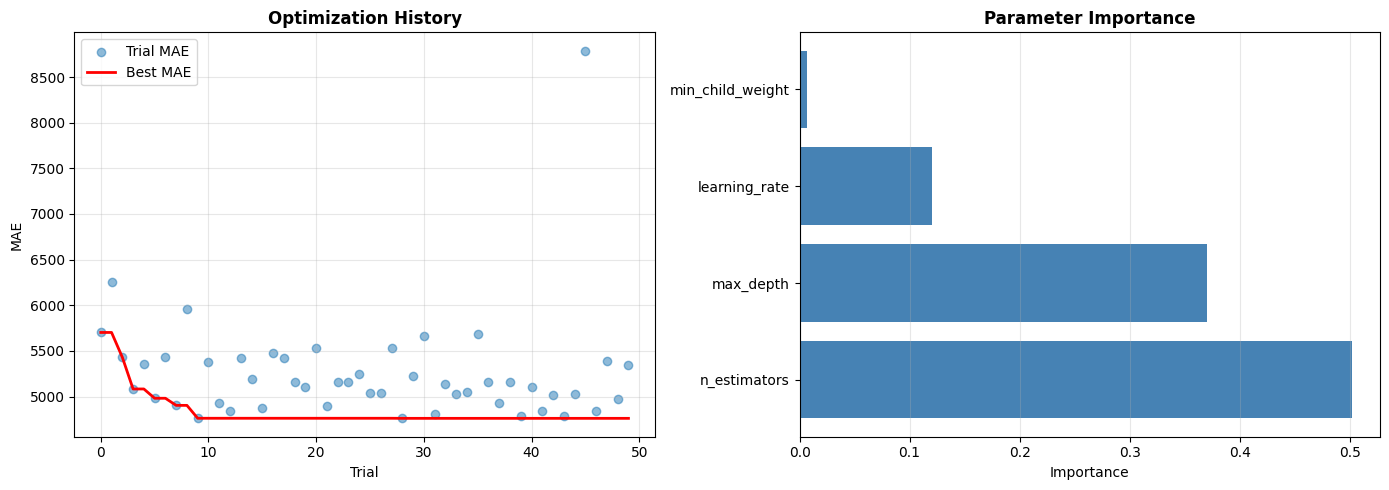

In [10]:
# Plot optimization history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Optimization history
ax1 = axes[0]
trials = [t.number for t in study.trials]
values = [t.value for t in study.trials]
best_values = [min(values[:i+1]) for i in range(len(values))]

ax1.scatter(trials, values, alpha=0.5, label='Trial MAE')
ax1.plot(trials, best_values, 'r-', linewidth=2, label='Best MAE')
ax1.set_xlabel('Trial')
ax1.set_ylabel('MAE')
ax1.set_title('Optimization History', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Parameter importance
ax2 = axes[1]
importances = optuna.importance.get_param_importances(study)
params = list(importances.keys())
values = list(importances.values())

ax2.barh(params, values, color='steelblue')
ax2.set_xlabel('Importance')
ax2.set_title('Parameter Importance', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [11]:
# Show top 10 trials
print("\nTop 10 Trials:")
print("-"*80)

trials_df = study.trials_dataframe()
trials_df = trials_df.sort_values('value').head(10)
display_cols = ['number', 'value', 'params_n_estimators', 'params_max_depth', 
                'params_learning_rate', 'params_min_child_weight']
trials_df[display_cols].round(4)


Top 10 Trials:
--------------------------------------------------------------------------------


,number,value,params_n_estimators,params_max_depth,params_learning_rate,params_min_child_weight
28,28,4761.3693,88,3,0.1105,8
9,9,4762.1718,187,3,0.1025,5
43,43,4789.9625,125,3,0.1107,10
39,39,4790.6306,176,3,0.0817,9
31,31,4813.4323,107,3,0.1171,7
41,41,4841.9597,178,3,0.0832,9
46,46,4844.1663,127,3,0.1725,10
12,12,4846.3656,150,3,0.0867,4
15,15,4872.0355,137,3,0.1227,7
21,21,4892.2534,119,3,0.1541,7


## 6. Validate Best Model

In [12]:
# Create tuned model with best parameters
best_params = study.best_params

tuned_model = XGBoostModel(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    lags=[1, 7, 14],
    external_features=EXTERNAL_FEATURES,
    name='XGBoost_Tuned'
)

# Create default model for comparison
default_model = XGBoostModel(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    lags=[1, 7, 14],
    external_features=EXTERNAL_FEATURES,
    name='XGBoost_Default'
)

print("Models created for comparison")

Models created for comparison


In [13]:
# Run full validation on both models
print("Running full validation...")

results = {}
for model in [default_model, tuned_model]:
    fold_results = validator.validate(
        model=model,
        df=df_features,
        target=TARGET,
        date_column=DATE_COLUMN,
        feature_columns=EXTERNAL_FEATURES + [DATE_COLUMN]
    )
    
    mae_values = [r['metrics']['mae'] for r in fold_results]
    mape_values = [r['metrics']['mape'] for r in fold_results]
    
    results[model.name] = {
        'mae_mean': np.mean(mae_values),
        'mae_std': np.std(mae_values),
        'mape_mean': np.mean(mape_values),
        'mape_std': np.std(mape_values),
    }

print("Validation complete!")

Running full validation...


Validation complete!


In [14]:
# Display comparison
print("="*70)
print("MODEL COMPARISON: Default vs Tuned")
print("="*70)

for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"  MAE:  {metrics['mae_mean']:.2f} (+/- {metrics['mae_std']:.2f})")
    print(f"  MAPE: {metrics['mape_mean']:.2f}% (+/- {metrics['mape_std']:.2f}%)")

# Calculate improvement
default_mae = results['XGBoost_Default']['mae_mean']
tuned_mae = results['XGBoost_Tuned']['mae_mean']
improvement = ((default_mae - tuned_mae) / default_mae) * 100

print("\n" + "="*70)
print(f"IMPROVEMENT: {improvement:.1f}% reduction in MAE")
print("="*70)

MODEL COMPARISON: Default vs Tuned

XGBoost_Default:
  MAE:  5285.34 (+/- 3305.73)
  MAPE: 10.00% (+/- 3.86%)

XGBoost_Tuned:
  MAE:  4761.37 (+/- 2813.69)
  MAPE: 9.25% (+/- 3.52%)

IMPROVEMENT: 9.9% reduction in MAE


## 7. Save Results

In [15]:
# Save best parameters to JSON
output_path = project_root / "data" / "processed" / "best_xgboost_params.json"
output_path.parent.mkdir(parents=True, exist_ok=True)

params_to_save = {
    'best_params': study.best_params,
    'best_mae': study.best_value,
    'n_trials': len(study.trials),
    'default_comparison': {
        'default_mae': results['XGBoost_Default']['mae_mean'],
        'tuned_mae': results['XGBoost_Tuned']['mae_mean'],
        'improvement_pct': improvement
    }
}

with open(output_path, 'w') as f:
    json.dump(params_to_save, f, indent=2)

print(f"Best parameters saved to: {output_path}")

Best parameters saved to: C:\Users\juanlu\dev\volume-forecasting-poc\data\processed\best_xgboost_params.json


In [16]:
# Display final summary
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"\nBest Parameters:")
for param, value in study.best_params.items():
    if isinstance(value, float):
        print(f"  {param}: {value:.4f}")
    else:
        print(f"  {param}: {value}")

print(f"\nPerformance:")
print(f"  Default MAE:  {results['XGBoost_Default']['mae_mean']:.2f}")
print(f"  Tuned MAE:    {results['XGBoost_Tuned']['mae_mean']:.2f}")
print(f"  Improvement:  {improvement:.1f}%")

print(f"\nDefault MAPE:  {results['XGBoost_Default']['mape_mean']:.2f}%")
print(f"Tuned MAPE:    {results['XGBoost_Tuned']['mape_mean']:.2f}%")


FINAL SUMMARY

Best Parameters:
  n_estimators: 88
  max_depth: 3
  learning_rate: 0.1105
  min_child_weight: 8

Performance:
  Default MAE:  5285.34
  Tuned MAE:    4761.37
  Improvement:  9.9%

Default MAPE:  10.00%
Tuned MAPE:    9.25%


## 8. LightGBM Hyperparameter Tuning

Now let's tune LightGBM with the same approach.

In [17]:
def lightgbm_objective(trial: optuna.Trial) -> float:
    """Optuna objective function for LightGBM hyperparameter optimization."""
    # Sample hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 127),
    }
    
    # Create model with sampled parameters
    model = LightGBMModel(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        num_leaves=params['num_leaves'],
        lags=[1, 7, 14],
        external_features=EXTERNAL_FEATURES,
        name='LightGBM_Tuning'
    )
    
    # Run walk-forward validation
    fold_results = validator.validate(
        model=model,
        df=df_features,
        target=TARGET,
        date_column=DATE_COLUMN,
        feature_columns=EXTERNAL_FEATURES + [DATE_COLUMN]
    )
    
    # Calculate mean MAE
    mae_values = [r['metrics']['mae'] for r in fold_results]
    mean_mae = np.mean(mae_values)
    
    return mean_mae

print("LightGBM objective function defined")

LightGBM objective function defined


In [18]:
# Create LightGBM study and run optimization
lightgbm_study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=10)
)

print("Starting LightGBM hyperparameter optimization...")
print(f"Trials: 50 | Folds per trial: {n_folds}")
print("="*60)

def lightgbm_callback(study: optuna.Study, trial: optuna.trial.FrozenTrial):
    if trial.number % 5 == 0 or trial.number == 0:
        print(f"Trial {trial.number:3d}: MAE = {trial.value:.2f} | Best so far: {study.best_value:.2f}")

lightgbm_study.optimize(
    lightgbm_objective,
    n_trials=50,
    callbacks=[lightgbm_callback],
    show_progress_bar=True
)

print("="*60)
print("LightGBM optimization complete!")

Starting LightGBM hyperparameter optimization...
Trials: 50 | Folds per trial: 52


  0%|          | 0/50 [00:00<?, ?it/s]

Trial   0: MAE = 6003.97 | Best so far: 6003.97


Trial   5: MAE = 5738.38 | Best so far: 5703.73


Trial  10: MAE = 5792.28 | Best so far: 5703.73


Trial  15: MAE = 5774.00 | Best so far: 5695.21


Trial  20: MAE = 5989.18 | Best so far: 5695.21


Trial  25: MAE = 5677.90 | Best so far: 5677.90


Trial  30: MAE = 5973.44 | Best so far: 5677.90


Trial  35: MAE = 5685.03 | Best so far: 5666.67


Trial  40: MAE = 5721.13 | Best so far: 5666.67


Trial  45: MAE = 6295.37 | Best so far: 5666.67


LightGBM optimization complete!


In [19]:
# Display LightGBM best parameters
print("="*60)
print("LIGHTGBM BEST HYPERPARAMETERS")
print("="*60)
print(f"\nBest MAE: {lightgbm_study.best_value:.2f}")
print(f"\nBest Parameters:")
for param, value in lightgbm_study.best_params.items():
    if isinstance(value, float):
        print(f"  {param}: {value:.4f}")
    else:
        print(f"  {param}: {value}")

# Save LightGBM best parameters
lightgbm_params_path = project_root / "data" / "processed" / "best_lightgbm_params.json"
lightgbm_params_to_save = {
    'best_params': lightgbm_study.best_params,
    'best_mae': lightgbm_study.best_value,
    'n_trials': len(lightgbm_study.trials),
}
with open(lightgbm_params_path, 'w') as f:
    json.dump(lightgbm_params_to_save, f, indent=2)
print(f"\nBest parameters saved to: {lightgbm_params_path}")

LIGHTGBM BEST HYPERPARAMETERS

Best MAE: 5666.67

Best Parameters:
  n_estimators: 299
  max_depth: 5
  learning_rate: 0.0115
  num_leaves: 52

Best parameters saved to: C:\Users\juanlu\dev\volume-forecasting-poc\data\processed\best_lightgbm_params.json


## 9. Prophet Hyperparameter Tuning

Now let's tune Prophet's seasonality and changepoint parameters.

In [20]:
def prophet_objective(trial: optuna.Trial) -> float:
    """Optuna objective function for Prophet hyperparameter optimization."""
    # Sample hyperparameters
    params = {
        # Seasonality parameters
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10.0, log=True),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
        # Changepoint parameters
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True),
        'n_changepoints': trial.suggest_int('n_changepoints', 10, 50),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.7, 0.95),
    }
    
    # Create model with sampled parameters
    model = ProphetModel(
        yearly_seasonality=True,
        weekly_seasonality=True,
        regressors=PROPHET_REGRESSORS,
        name='Prophet_Tuning',
        **params
    )
    
    # Run walk-forward validation
    fold_results = validator.validate(
        model=model,
        df=df_features,
        target=TARGET,
        date_column=DATE_COLUMN,
        feature_columns=PROPHET_REGRESSORS + [DATE_COLUMN]
    )
    
    # Calculate mean MAE
    mae_values = [r['metrics']['mae'] for r in fold_results]
    mean_mae = np.mean(mae_values)
    
    return mean_mae

print("Prophet objective function defined")

Prophet objective function defined


In [21]:
# Create Prophet study and run optimization
prophet_study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=10)
)

print("Starting Prophet hyperparameter optimization...")
print(f"Trials: 50 | Folds per trial: {n_folds}")
print("="*60)

def prophet_callback(study: optuna.Study, trial: optuna.trial.FrozenTrial):
    if trial.number % 5 == 0 or trial.number == 0:
        print(f"Trial {trial.number:3d}: MAE = {trial.value:.2f} | Best so far: {study.best_value:.2f}")

prophet_study.optimize(
    prophet_objective,
    n_trials=50,
    callbacks=[prophet_callback],
    show_progress_bar=True
)

print("="*60)
print("Prophet optimization complete!")

Starting Prophet hyperparameter optimization...
Trials: 50 | Folds per trial: 52


  0%|          | 0/50 [00:00<?, ?it/s]

17:42:05 - cmdstanpy - INFO - Chain [1] start processing


17:42:05 - cmdstanpy - INFO - Chain [1] done processing


Trial   0: MAE = 5615.59 | Best so far: 5615.59


17:42:45 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Optimization terminated abnormally. Falling back to Newton.


Trial   5: MAE = 5892.09 | Best so far: 5600.51


Trial  10: MAE = 5876.06 | Best so far: 5600.51


Trial  15: MAE = 5512.87 | Best so far: 5512.87


17:45:43 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Optimization terminated abnormally. Falling back to Newton.


17:45:44 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Optimization terminated abnormally. Falling back to Newton.


17:45:46 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Optimization terminated abnormally. Falling back to Newton.


17:45:51 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Optimization terminated abnormally. Falling back to Newton.


17:45:53 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Optimization terminated abnormally. Falling back to Newton.


17:45:56 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Optimization terminated abnormally. Falling back to Newton.


17:46:28 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Optimization terminated abnormally. Falling back to Newton.


17:46:29 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Optimization terminated abnormally. Falling back to Newton.


17:46:33 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Optimization terminated abnormally. Falling back to Newton.


17:46:34 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Optimization terminated abnormally. Falling back to Newton.


17:46:36 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Optimization terminated abnormally. Falling back to Newton.


17:46:37 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Optimization terminated abnormally. Falling back to Newton.


17:46:42 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Optimization terminated abnormally. Falling back to Newton.


17:46:43 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Optimization terminated abnormally. Falling back to Newton.


17:46:46 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Optimization terminated abnormally. Falling back to Newton.


17:46:51 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Optimization terminated abnormally. Falling back to Newton.


Trial  20: MAE = 5564.59 | Best so far: 5512.87


Trial  25: MAE = 5534.06 | Best so far: 5476.69


17:48:32 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Optimization terminated abnormally. Falling back to Newton.


17:48:33 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Optimization terminated abnormally. Falling back to Newton.


17:48:40 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Optimization terminated abnormally. Falling back to Newton.


17:48:49 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Optimization terminated abnormally. Falling back to Newton.


Trial  30: MAE = 5564.90 | Best so far: 5476.69


17:50:13 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Optimization terminated abnormally. Falling back to Newton.


17:50:16 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Optimization terminated abnormally. Falling back to Newton.


Trial  35: MAE = 5503.22 | Best so far: 5476.69


17:51:11 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted


Optimization terminated abnormally. Falling back to Newton.


Trial  40: MAE = 6659.12 | Best so far: 5476.69


Trial  45: MAE = 5504.80 | Best so far: 5476.69


Prophet optimization complete!


In [22]:
# Display Prophet best parameters
print("="*60)
print("PROPHET BEST HYPERPARAMETERS")
print("="*60)
print(f"\nBest MAE: {prophet_study.best_value:.2f}")
print(f"\nBest Parameters:")
for param, value in prophet_study.best_params.items():
    if isinstance(value, float):
        print(f"  {param}: {value:.4f}")
    else:
        print(f"  {param}: {value}")

# Save Prophet best parameters
prophet_params_path = project_root / "data" / "processed" / "best_prophet_params.json"
prophet_params_to_save = {
    'best_params': prophet_study.best_params,
    'best_mae': prophet_study.best_value,
    'n_trials': len(prophet_study.trials),
}
with open(prophet_params_path, 'w') as f:
    json.dump(prophet_params_to_save, f, indent=2)
print(f"\nBest parameters saved to: {prophet_params_path}")

PROPHET BEST HYPERPARAMETERS

Best MAE: 5476.69

Best Parameters:
  seasonality_prior_scale: 0.0101
  seasonality_mode: additive
  changepoint_prior_scale: 0.0117
  n_changepoints: 44
  changepoint_range: 0.7968

Best parameters saved to: C:\Users\juanlu\dev\volume-forecasting-poc\data\processed\best_prophet_params.json


## 10. Final Summary - All Tuned Models

In [23]:
# Final summary of all tuned models
print("="*70)
print("HYPERPARAMETER TUNING SUMMARY")
print("="*70)

print("\n1. XGBoost (Best MAE: {:.2f})".format(study.best_value))
for param, value in study.best_params.items():
    if isinstance(value, float):
        print(f"   {param}: {value:.4f}")
    else:
        print(f"   {param}: {value}")

print("\n2. LightGBM (Best MAE: {:.2f})".format(lightgbm_study.best_value))
for param, value in lightgbm_study.best_params.items():
    if isinstance(value, float):
        print(f"   {param}: {value:.4f}")
    else:
        print(f"   {param}: {value}")

print("\n3. Prophet (Best MAE: {:.2f})".format(prophet_study.best_value))
for param, value in prophet_study.best_params.items():
    if isinstance(value, float):
        print(f"   {param}: {value:.4f}")
    else:
        print(f"   {param}: {value}")

print("\n" + "="*70)
print("Use these parameters in notebook 07 for the Ensemble_Tuned model")
print("="*70)

HYPERPARAMETER TUNING SUMMARY

1. XGBoost (Best MAE: 4761.37)
   n_estimators: 88
   max_depth: 3
   learning_rate: 0.1105
   min_child_weight: 8

2. LightGBM (Best MAE: 5666.67)
   n_estimators: 299
   max_depth: 5
   learning_rate: 0.0115
   num_leaves: 52

3. Prophet (Best MAE: 5476.69)
   seasonality_prior_scale: 0.0101
   seasonality_mode: additive
   changepoint_prior_scale: 0.0117
   n_changepoints: 44
   changepoint_range: 0.7968

Use these parameters in notebook 07 for the Ensemble_Tuned model
